In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap

from mergeplg import merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openrainer_AWS.nc")
ds_cmls = xr.open_dataset("./data/openrainer_CML.nc")
ds_rad = xr.open_dataset("./data/openrainer_RAD.nc")

# fix CML files
ds_cmls = ds_cmls.reduce(np.nanmean, dim="sublink_id")

# fix RG files
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})

# fix radar files
ds_rad = ds_rad.rename({"lon": "x", "lat": "y"})

ys = [ds_rad.y.values,] * len(ds_rad.x.values)  # fmt: skip
xs = [ds_rad.x.values,] * len(ds_rad.y.values)  # fmt: skip
ds_rad["lat"] = (("y", "x"), np.array(ys).transpose())
ds_rad["lon"] = (("y", "x"), np.array(xs))

ds_rad = ds_rad.set_coords(["lon", "lat"])

In [4]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

# Adjust rainfall fields

In [9]:
# Do adjustment using multiplicative IDW
multiplicativeIDW = merge.MergeMultiplicativeIDW()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        multiplicativeIDW.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
        )
    )
ds_rad["rainfall_multiplicativeIDW"] = xr.concat(adjusted_rainfall, dim="time")

In [10]:
# Do adjustment using additive IDW
additiveIDW = merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveIDW.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(adjusted_rainfall, dim="time")

In [11]:
# Do adjustment using additive Block-Kriging
additiveBlockKriging = merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
        )
    )
ds_rad["rainfall_additiveBK"] = xr.concat(adjusted_rainfall, dim="time")

In [12]:
# Do adjustment using KED
KEDBlockKriging = merge.MergeBlockKrigingExternalDrift()

# Do adjustment
adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        KEDBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(adjusted_rainfall, dim="time")

In [13]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

C:\Users\Utente\AppData\Local\Temp\ipykernel_13372\3692545339.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(
C:\Users\Utente\AppData\Local\Temp\ipykernel_13372\3692545339.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(
C:\Users\Utente\AppData\Local\Temp\ipykernel_13372\3692545339.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax

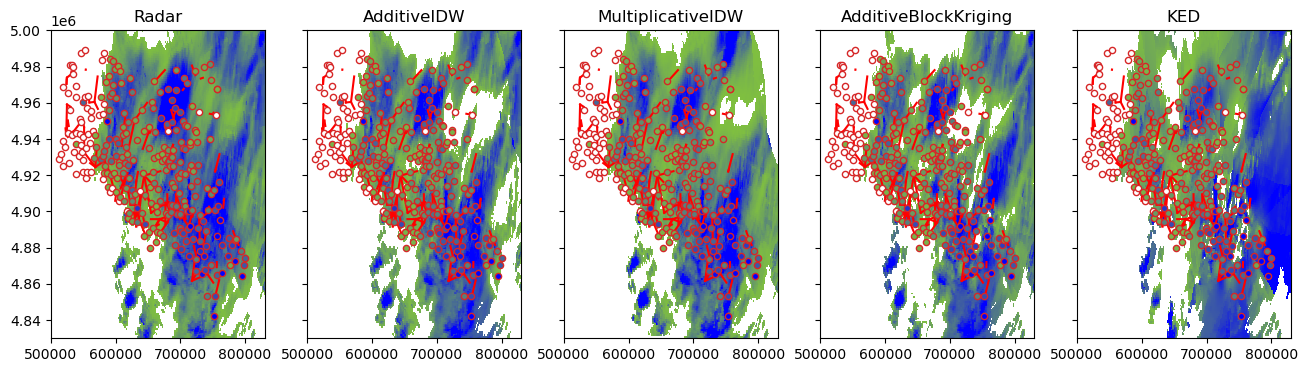

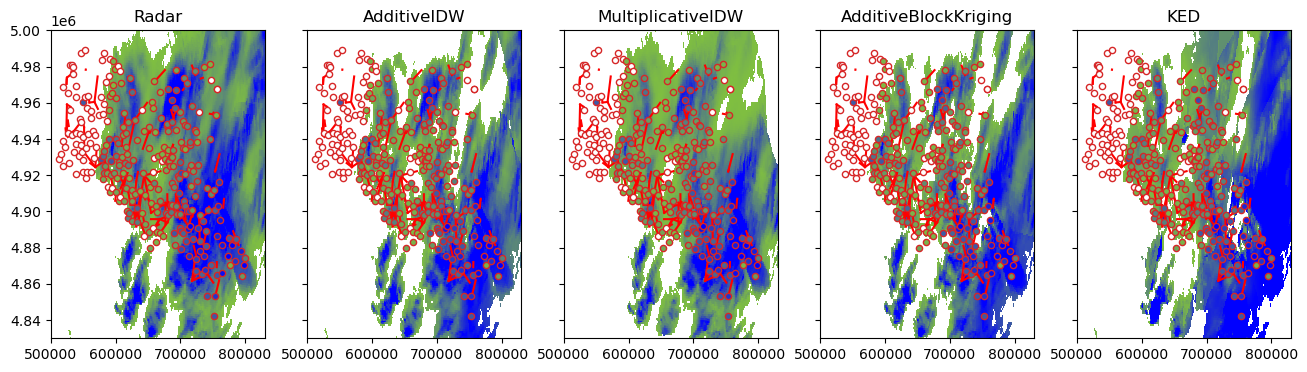

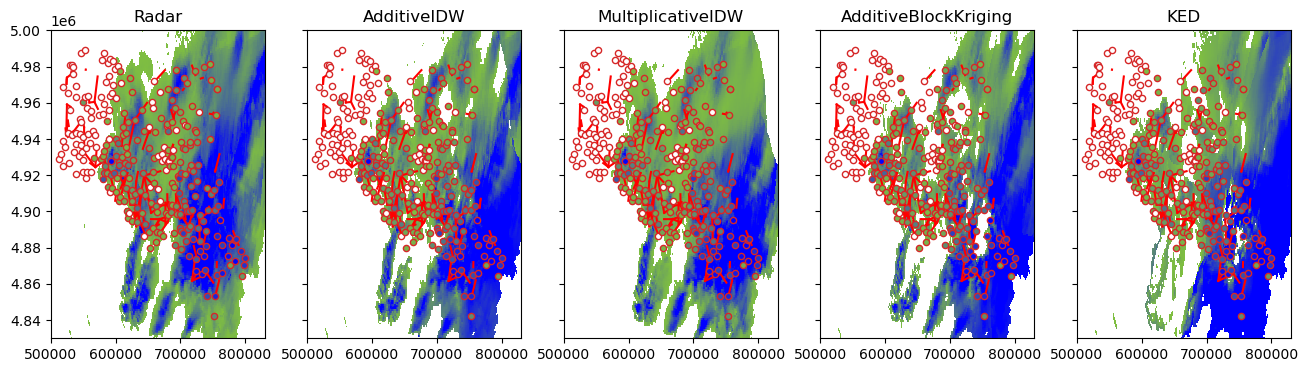

In [14]:
vmax = 3  # max color

# Time interval to plot
time_start = "2022-09-17T09:45"
time_end = "2022-09-17T10:15"
for time in ds_cmls.sel(time=slice(time_start, time_end)).time:
    fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )

    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveIDW.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_multiplicativeIDW.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveBK.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[4].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_KED.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[0].set_title("Radar")
    ax[1].set_title("AdditiveIDW")
    ax[2].set_title("MultiplicativeIDW")
    ax[3].set_title("AdditiveBlockKriging")
    ax[4].set_title("KED")
    for p in range(5):
        ax[p].set_xlim(5e5, 8.3e5)
        ax[p].set_ylim(4.830e6, 5e6)

    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )

    for ax_i in range(len(ax)):
        for station_id in ds_gauges.id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=0,
                vmax=vmax,
                s=20,
                zorder=2,
            )
    plt.show()

# Compare to city rain gauges

In [15]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
)

IDW_add_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges.rainfall_amount,
)

IDW_mul_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_multiplicativeIDW,
    da_point_data=ds_gauges.rainfall_amount,
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges.rainfall_amount,
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges.rainfall_amount,
)

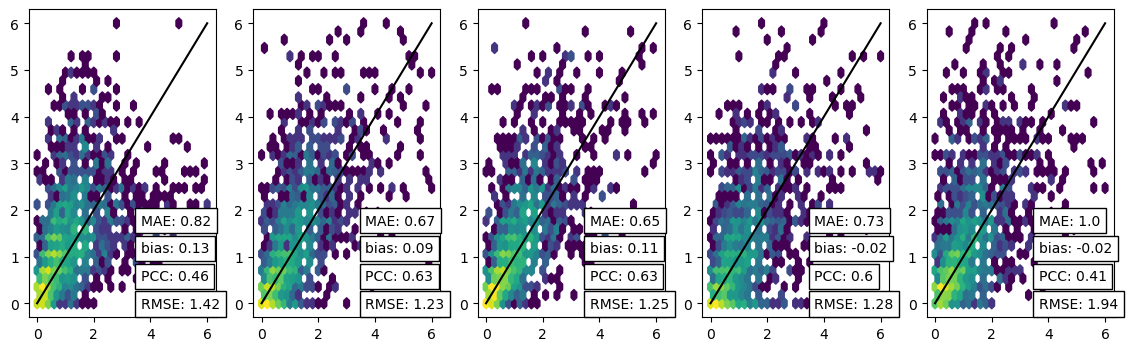

In [16]:
extent = [0, 6, 0, 6]
gridsize = 30

pred_models = [
    radar_at_points,
    IDW_add_at_points,
    IDW_mul_at_points,
    BK_at_points,
    KED_at_points,
]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()
    keep = np.ones(ground.shape).astype(bool)
    # ground contains NaNs
    keep = (radar_at_points.data.ravel() > 0) & (~np.isnan(ground))
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")